## Lecture 1: The spelled-out intro to language modeling: building makemore
#### https://youtu.be/PaCmpygFfXo?si=k6LLLYjKk-MuGOmA

In [1]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as f
import numpy as np

In [2]:
names = open("names.txt", "r").read().splitlines()

In [3]:
len(names)

32033

In [4]:
print(f"Smallest name length: {min(len(n) for n in names)}")
print(f"Longest name length: {max(len(n) for n in names)}")

Smallest name length: 2
Longest name length: 15


## Bigram Frequentist Approach

In [5]:
# Print bigrams
bigram_counts = defaultdict(int)
for name in names:
    name = ["<S>"] + list(name) + ["<E>"]
    for n1, n2 in zip(name,name[1:]):
        # print(n1, n2)
        bigram_counts[(n1,n2)] += 1

In [6]:
# bigram_counts # {('word1', 'word2'): num}

In [7]:
sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:10]
# sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[-10:]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

#### Array

In [8]:
mapping = dict()
for i, l in enumerate("abcdefghijklmnopqrstuvwxyz"):
    mapping[l] = i
mapping["<S>"] = 26
mapping["<E>"] = 27

In [9]:
empty = torch.zeros((28,28), dtype=torch.int32)

In [10]:
for bigram, freq in bigram_counts.items():
    empty[mapping[bigram[0]], mapping[bigram[1]]] = freq

In [11]:
# fig, ax = plt.subplots(figsize=(15,15))
# im = ax.imshow(empty)

# for i in range(28):
#     for j in range(28):
#         ax.text(i, j-0.2, empty[j,i].item(), ha="center", va="center", color="w")
#         ax.text(i, j+0.2, list(mapping.keys())[j]+list(mapping.keys())[i], ha="center", va="center", color="w")

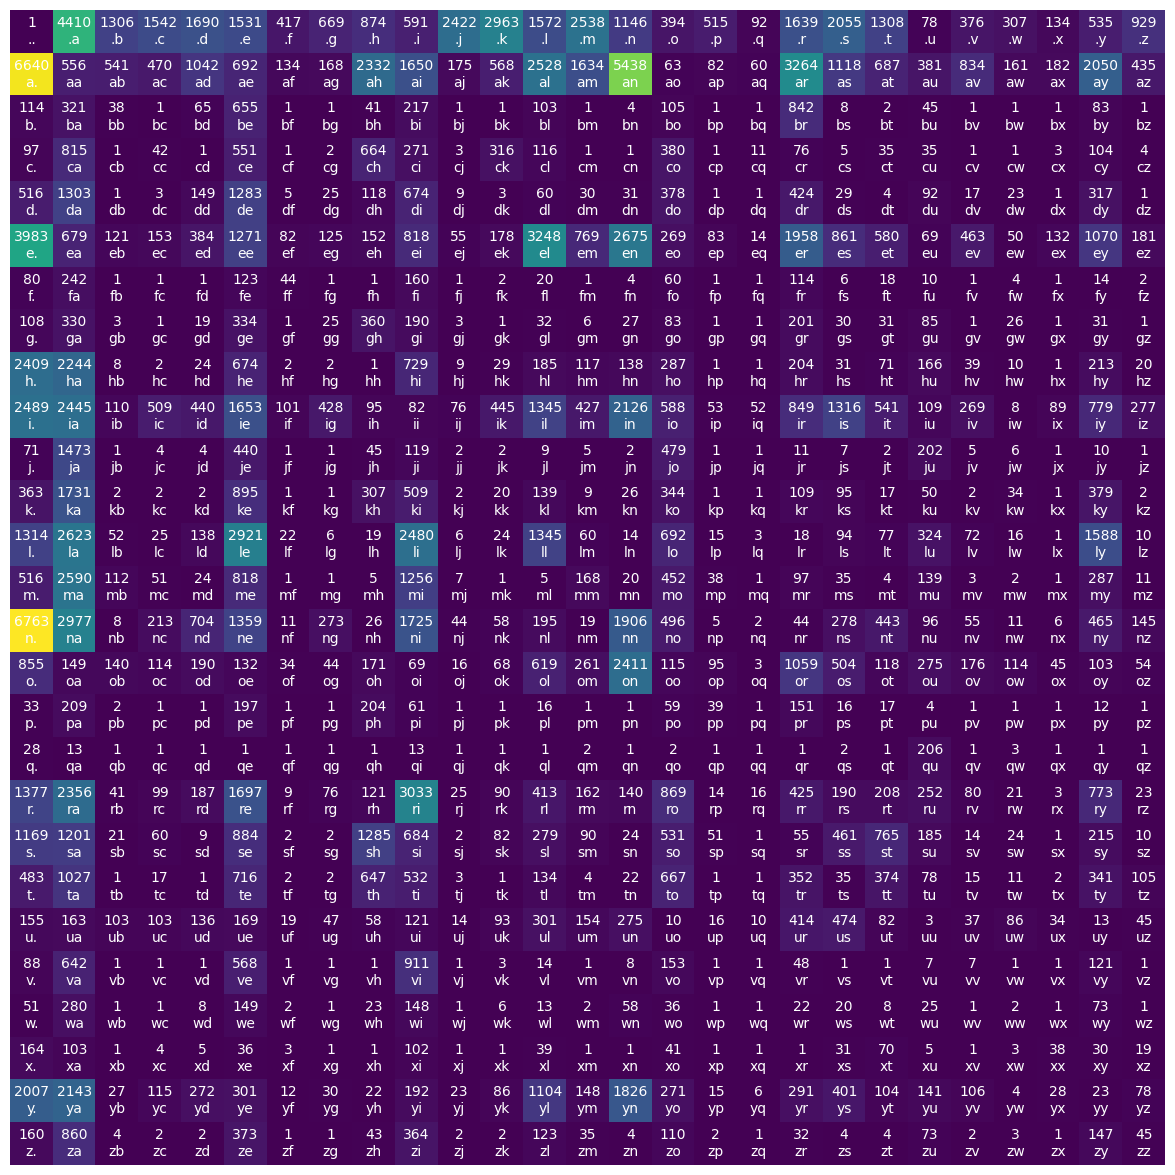

In [12]:
# Alternate array
bigram_counts = defaultdict(int)
for name in names:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name,name[1:]):
        # print(n1, n2)
        bigram_counts[(n1,n2)] += 1

mapping2 = dict()
for i, l in enumerate("abcdefghijklmnopqrstuvwxyz", 1):
    mapping2[l] = i
mapping2["."] = 0

empty = torch.zeros((27,27), dtype=torch.int32)
empty += 1  # Model Smoothing
for bigram, freq in bigram_counts.items():
    empty[mapping2[bigram[0]], mapping2[bigram[1]]] = freq

rev_mapping2 = {num:char for char, num in mapping2.items()}

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(empty)

for i in range(27):
    for j in range(27):
        ax.text(i, j-0.2, empty[j,i].item(), ha="center", va="center", color="w")
        ax.text(i, j+0.2, rev_mapping2[j]+rev_mapping2[i], ha="center", va="center", color="w")
plt.axis("off");

### Sampling Bigrams

In [13]:
# First sample the .letter row
# Then based on previous sample, sample from the next rows
# run the loop till . is sampled

In [14]:
# First letter sampling probablities
fs = empty[0,:]/empty[0,:].sum()
fs

tensor([3.1217e-05, 1.3767e-01, 4.0769e-02, 4.8136e-02, 5.2756e-02, 4.7793e-02,
        1.3017e-02, 2.0884e-02, 2.7284e-02, 1.8449e-02, 7.5607e-02, 9.2495e-02,
        4.9073e-02, 7.9228e-02, 3.5774e-02, 1.2299e-02, 1.6077e-02, 2.8719e-03,
        5.1164e-02, 6.4151e-02, 4.0832e-02, 2.4349e-03, 1.1738e-02, 9.5836e-03,
        4.1831e-03, 1.6701e-02, 2.9000e-02])

In [15]:
overall_dist = empty/empty.sum(dim=1, keepdim=True)

In [16]:
g = torch.Generator().manual_seed(2147483647)

In [17]:
for prediction in range(10):
    next_l = torch.multinomial(overall_dist[0],num_samples=1,replacement=True,generator=g).item()
    letters = []
    while next_l != 0:
        letters.append(rev_mapping2[next_l])
        next_l = torch.multinomial(overall_dist[next_l],num_samples=1,replacement=True,generator=g).item()
    print("".join(letters))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


In [18]:
# mapping2

In [19]:
log_likelihood = 0
n = 0

for name in names:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name,name[1:]):
        # print(f"{n1, n2}: {overall_dist[mapping2[n1],mapping2[n2]]:.4f}, log prob: {torch.log(overall_dist[mapping2[n1],mapping2[n2]]):.4f}")
        log_prob = torch.log(overall_dist[mapping2[n1],mapping2[n2]])
        log_likelihood += log_prob
        n += 1
        
print(f"log Likelihood: {log_likelihood}")
print(f"Negative log Likelihood: {-log_likelihood}")
print(f"Average Negative log Likelihood: {(-log_likelihood)/n}")

log Likelihood: -560008.5625
Negative log Likelihood: 560008.5625
Average Negative log Likelihood: 2.454606056213379


In [20]:
log_likelihood = 0
n = 0

for name in ["palakuru"]:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name,name[1:]):
        print(f"{n1, n2}: {overall_dist[mapping2[n1],mapping2[n2]]:.4f}, log prob: {torch.log(overall_dist[mapping2[n1],mapping2[n2]]):.4f}")
        log_prob = torch.log(overall_dist[mapping2[n1],mapping2[n2]])
        log_likelihood += log_prob
        n += 1
        
print(f"log Likelihood: {log_likelihood}")
print(f"Negative log Likelihood: {-log_likelihood}")
print(f"Average Negative log Likelihood: {(-log_likelihood)/n}")

('.', 'p'): 0.0161, log prob: -4.1304
('p', 'a'): 0.2023, log prob: -1.5979
('a', 'l'): 0.0746, log prob: -2.5955
('l', 'a'): 0.1879, log prob: -1.6718
('a', 'k'): 0.0168, log prob: -4.0886
('k', 'u'): 0.0099, log prob: -4.6139
('u', 'r'): 0.1321, log prob: -2.0245
('r', 'u'): 0.0198, log prob: -3.9199
('u', '.'): 0.0494, log prob: -3.0070
log Likelihood: -27.649568557739258
Negative log Likelihood: 27.649568557739258
Average Negative log Likelihood: 3.072174310684204


## Neural Network Approach

In [21]:
# Creating the training set of bigrams (x, y), x is input and y is target
xs, ys = [], []
for name in names[:1]:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name, name[1:]):
        xs.append(mapping2[n1])
        ys.append(mapping2[n2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [22]:
# One hot encoding inputs
ohe_xs = f.one_hot(xs,num_classes=27).float()
ohe_xs

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [23]:
W = torch.randn([27,27])

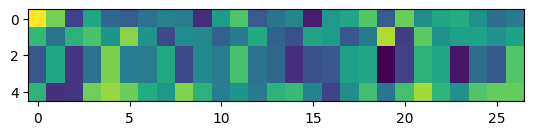

In [24]:
plt.imshow(ohe_xs @ W)

In [25]:
# Untrained Neural Network output to probabilities
logits = ohe_xs @ W # NN output
counts = logits.exp() # Exponentiate to convert negative values to positive (if input -ve = output < 1)
probs = counts / counts.sum(dim=1, keepdim=True) # Normalising counts to get probabilities
# Softmax is lst 2 lines

In [26]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([27,27], generator=g)

logits = ohe_xs @ W # NN output
counts = logits.exp() # Exponentiate to convert negative values to positive (if input -ve = output < 1)
probs = counts / counts.sum(dim=1, keepdim=True)

In [27]:
for name in names[:1]:
    name = ["."] + list(name) + ["."]
    cnt = 0
    loss = 0
    for n1, n2 in zip(name, name[1:]):
        print(f"input: {n1}, target: {n2}")
        prob = probs[cnt,mapping2[n2]]
        log_prob = -(torch.log(prob))
        loss += log_prob
        print(f"loss: {log_prob}")
        cnt += 1

input: ., target: e
loss: 4.3992743492126465
input: e, target: m
loss: 4.014570713043213
input: m, target: m
loss: 3.623408794403076
input: m, target: a
loss: 2.6080667972564697
input: a, target: .
loss: 4.201204299926758


In [28]:
loss/5

tensor(3.7693)

In [29]:
xs, ys = [], []
for name in names:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name,name[1:]):
        xs.append(mapping2[n1])
        ys.append(mapping2[n2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

g = torch.Generator().manual_seed(2147483647)
W = torch.randn([27,27], generator=g, requires_grad=True)

In [30]:
num

228146

In [31]:
for e in range(10):

    # Forward Pass
    ohe = f.one_hot(xs, num_classes=27).float()
    logits = ohe @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())

    # Backward Pass
    W.grad = None
    loss.backward()

    # Update
    W.data += -50 * W.grad

3.758953809738159
3.371100664138794
3.154043197631836
3.020373821258545
2.927711248397827
2.8604023456573486
2.8097290992736816
2.7701022624969482
2.7380728721618652
2.711496591567993


loss of 2.71 was achieved after several epochs

## Exercises

### E01: Trigram Model

In [32]:
names[1]

'olivia'

In [33]:
n1 = 0
while n1 < len(names[1])-2:
    print(names[1][n1:n1+2], names[1][n1+2])
    n1 += 1

ol i
li v
iv i
vi a


In [34]:
trigram_counts = defaultdict(int)
for name in names:
    name = ["."] + list(name) + ["."]
    n1 = 0
    while n1 < len(name)-2:
        # print("".join(name[n1:n1+2]), name[n1+2])
        trigram_counts["".join(name[n1:n1+2]), name[n1+2]] += 1
        n1 += 1

In [35]:
print(len(bigram_counts))
print(len(trigram_counts))

627
6037


In [36]:
sorted(trigram_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[(('ah', '.'), 1714),
 (('na', '.'), 1673),
 (('an', '.'), 1509),
 (('on', '.'), 1503),
 (('.m', 'a'), 1453),
 (('.j', 'a'), 1255),
 (('.k', 'a'), 1254),
 (('en', '.'), 1217),
 (('ly', 'n'), 976),
 (('yn', '.'), 953)]

In [37]:
# alpha

In [38]:
one_two_mapping = dict()
cnt = 0
for a1 in ".abcdefghijklmnopqrstuvwxyz":
    for a2 in "abcdefghijklmnopqrstuvwxyz":
        one_two_mapping[a1+a2] = cnt
        cnt += 1

In [39]:
three_mapping = {a:idx for idx,a in enumerate(".abcdefghijklmnopqrstuvwxyz")}

In [40]:
trigram_count_matrix = torch.zeros([702, 27])

In [41]:
for word, cnt in trigram_counts.items():
    first_two = word[0]
    third = word[1]
    trigram_count_matrix[one_two_mapping[first_two], three_mapping[third]] = cnt

In [42]:
print(one_two_mapping["ah"])
print(trigram_count_matrix[33,0])

33
tensor(1714.)


In [43]:
trigram_count_matrix += 1

In [44]:
# Obtaining the probability matrix
trigram_prob_matrix = trigram_count_matrix / trigram_count_matrix.sum(dim=1, keepdim=True)

In [45]:
# trigram_prob_matrix.sum(dim=1)

In [46]:
ename = names[1]
ename

'olivia'

In [47]:
# Checking the loss
ename = ["."] + list(ename) + ["."]
n = 0
while n < len(ename)-2:
    print(ename[n:n+2], ename[n+2])
    x = one_two_mapping["".join(ename[n:n+2])]
    y = three_mapping[ename[n+2]]
    print(f"probs: {trigram_prob_matrix[x,y]}")
    n += 1

['.', 'o'] l
probs: 0.24940617382526398
['o', 'l'] i
probs: 0.10835913568735123
['l', 'i'] v
probs: 0.021938571706414223
['i', 'v'] i
probs: 0.2668918967247009
['v', 'i'] a
probs: 0.15778250992298126
['i', 'a'] .
probs: 0.3656958043575287


In [48]:
loss = 0
cnt = 0
for name in names:
    name = ["."] + list(name) + ["."]
    n = 0
    while n < len(name)-2:
        # print(ename[n:n+2], ename[n+2])
        x = one_two_mapping["".join(name[n:n+2])]
        y = three_mapping[name[n+2]]
        # print(f"probs: {trigram_prob_matrix[x,y]}")
        loss += -trigram_prob_matrix[x,y].log()
        n += 1
        cnt += 1

In [49]:
loss/cnt

tensor(2.0927)

A loss of 2.09 for trigram model

#### Neural Net Trigram

In [50]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([702,27], generator=g, requires_grad=True)

In [51]:
len(names)

32033

In [52]:
xs, ys = [], []
for name in names:
    n = 0
    name = ["."] + list(name) + ["."]
    while n < len(name)-2:
        # print(ename[n:n+2], ename[n+2])
        x = one_two_mapping["".join(name[n:n+2])]
        y = three_mapping[name[n+2]]
        # print(x)
        # print(f"{one_two_mapping_rev[x]}")
        # print(f"probs: {trigram_prob_matrix[x,y]}")
        xs.append(x)
        ys.append(y)
        n += 1

In [53]:
one_two_mapping_rev = {idx:t for t,idx in one_two_mapping.items()}
three_mapping_rev = {idx:t for t,idx in three_mapping.items()}

In [54]:
print(len(xs))
print(len(ys))

196113
196113


In [55]:
for epoch in range(5):
    
    ohe = f.one_hot(torch.tensor(xs), num_classes=702).float()
    logits = ohe @ W
    log_counts = logits.exp()
    probs = log_counts / log_counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(len(ys)),ys].log().mean()
    print(f"Loss in epoch {epoch+1}: {loss.item()}")
    
    W.grad = None
    loss.backward()

    W.data += -100 * W.grad

Loss in epoch 1: 3.7599074840545654
Loss in epoch 2: 3.596100091934204
Loss in epoch 3: 3.4591567516326904
Loss in epoch 4: 3.343820810317993
Loss in epoch 5: 3.2476694583892822


Improvement in model for trigram. Achieved a loss of 2.14 after 100 epoch with 100 as step size

### E02: Train, Val, & Test set

In [56]:
import random

In [57]:
random.seed(1)
test_idx = set(random.sample(range(32033),k=3200))
rest = set(range(32033)) - test_idx
dev_idx = set(random.sample(list(rest),k=3200))
train_idx = rest - dev_idx # Efficient way
train_set = [names[idx] for idx in train_idx]
dev_set = [names[idx] for idx in dev_idx]
test_set = [names[idx] for idx in test_idx]
print(len(train_set))
print(len(dev_set))
print(len(test_set))

25633
3200
3200


#### Bigram

In [58]:
# Creating Bigram Counts
bigram_counts = defaultdict(int)
for name in train_set:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name, name[1:]):
        bigram_counts[(n1, n2)] += 1

In [59]:
# Creating distribution matrix
dist_matrix = torch.zeros([27,27],dtype=torch.float32)
dist_matrix += 1
for bigram, freq in bigram_counts.items():
    dist_matrix[mapping2[bigram[0]], mapping2[bigram[1]]] = freq
dist_matrix = dist_matrix / dist_matrix.sum(dim=1,keepdim=True)

In [60]:
# Creating dev and testing data
xs_tr, ys_tr, xs_t, ys_t, xs_d, ys_d = [], [], [], [], [], []

for name in train_set:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name, name[1:]):
        xs_tr.append(mapping2[n1])
        ys_tr.append(mapping2[n2])

for name in test_set:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name, name[1:]):
        xs_t.append(mapping2[n1])
        ys_t.append(mapping2[n2])

for name in dev_set:
    name = ["."] + list(name) + ["."]
    for n1, n2 in zip(name, name[1:]):
        xs_d.append(mapping2[n1])
        ys_d.append(mapping2[n2])

In [61]:
# Checking train, dev and test loss
print(f"Training Loss: {-dist_matrix[xs_tr, ys_tr].log().mean()}")
print(f"Dev Loss: {-dist_matrix[xs_d, ys_d].log().mean()}")
print(f"Testing Loss: {-dist_matrix[xs_t, ys_t].log().mean()}")

Training Loss: 2.453339099884033
Dev Loss: 2.4590904712677
Testing Loss: 2.4631855487823486


#### Trigram

In [62]:
trigram_counts = defaultdict(int)
for name in train_set:
    name = ["."] + list(name) + ["."]
    n1 = 0
    while n1 < len(name)-2:
        trigram_counts["".join(name[n1:n1+2]), name[n1+2]] += 1
        n1 += 1

In [63]:
trigram_dist_matrix = torch.zeros([702, 27], dtype=torch.float32)
trigram_dist_matrix += 1
for word, cnt in trigram_counts.items():
    first_two = word[0]
    third = word[1]
    trigram_dist_matrix[one_two_mapping[first_two], three_mapping[third]] = cnt
trigram_dist_matrix = trigram_dist_matrix / trigram_dist_matrix.sum(dim=1, keepdim=True)

In [64]:
trigram_dist_matrix.max()

tensor(0.8268)

In [65]:
print(f"Training Loss: {-trigram_dist_matrix[xs_tr, ys_tr].log().mean()}")
print(f"Dev Loss: {-trigram_dist_matrix[xs_d, ys_d].log().mean()}")
print(f"Testing Loss: {-trigram_dist_matrix[xs_t, ys_t].log().mean()}")

Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207


### E03: Tuning Regularization

In [66]:
# trigram_dist_matrix = torch.zeros([702, 27], dtype=torch.float32)
# trigram_dist_matrix += 1
# for word, cnt in trigram_counts.items():
#     first_two = word[0]
#     third = word[1]
#     trigram_dist_matrix[one_two_mapping[first_two], three_mapping[third]] = cnt

for s in range(2,10):
    temp_trigram_dist_matrix = trigram_dist_matrix + s
    print(f"Losses for regularization {s} -----------------------------------")
    print(f"Training Loss: {-trigram_dist_matrix[xs_tr, ys_tr].log().mean()}")
    print(f"Dev Loss: {-trigram_dist_matrix[xs_d, ys_d].log().mean()}")
    print(f"Testing Loss: {-trigram_dist_matrix[xs_t, ys_t].log().mean()}")

Losses for regularization 2 -----------------------------------
Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207
Losses for regularization 3 -----------------------------------
Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207
Losses for regularization 4 -----------------------------------
Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207
Losses for regularization 5 -----------------------------------
Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207
Losses for regularization 6 -----------------------------------
Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207
Losses for regularization 7 -----------------------------------
Training Loss: 4.241032600402832
Dev Loss: 4.248585224151611
Testing Loss: 4.251133918762207
Losses for regularization 8 ------------------------------

Doubt!!

### E04: Remove f.one_hot

In [78]:
# Replace
# ohe = f.one_hot(torch.tensor(xs), num_classes=702).float()
# logits = ohe @ W
# with
# logits = W[ys,:]

### E05: f.cross_entropy

In [76]:
f.cross_entropy(logits, torch.tensor(ys))

tensor(3.2477, grad_fn=<NllLossBackward0>)

No clue what is difference between our implimentation and f.cross_entropy